<a href="https://colab.research.google.com/github/i1oveMyse1f/sirius/blob/master/sirius_pytorch_master.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch и MNIST

В этом задании предлагается обучить свёрточную нейросеть, определяющая, какая цифра нарисована на картинке, используя PyTorch.

## Загрузка библиотек

Сначала загрузим библиотеки, которые понадобятся

In [ ]:
import numpy as np

import torch
import torchvision
from torchvision import transforms

from tqdm import tqdm

from torch import nn
from torch.nn import functional as F

from torch.utils.data import DataLoader

from IPython.display import clear_output

import matplotlib.pyplot as plt

## Подготовка данных

Нейросеть будет обучаться на датасете рукописных цифр [MNIST](https://ru.wikipedia.org/wiki/MNIST_(%D0%B1%D0%B0%D0%B7%D0%B0_%D0%B4%D0%B0%D0%BD%D0%BD%D1%8B%D1%85)).

К счастью, в PyTorch уже встроен загрузчик этого датасета, и мы им воспользуемся. Но для начала зададим некоторые параметры для загрузчика:

1. Размер батча. PyTorch умеет подавать на обучение сразу не один объект, а несколько. В каком объёме &mdash; зависит от предоставленных вычислительных возможностей. Обычно ставят `batch_size` равным 64, 128, 256 или 512.

2. Предварительные преобразования. На лекции рассказывалось, что PyTorch умеет работать с тензорами, в то время как картинки с цифрами являются растровыми изображениями. Чтобы PyTorch мог с ними работать, нужно выполнить преобразования. Воспользуйтесь классами из [`torchvision.transforms`](https://pytorch.org/vision/stable/transforms.html): `ToTensor`, чтобы превратить изображение в тензор, `Normalize`, чтобы нормализовать его, и `Compose`, чтобы совместить преобразования.

In [ ]:
batch_size = 128

In [ ]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

Инициализируем загрузчик:

In [ ]:
train_data = torchvision.datasets.MNIST('./files/', train=True, download=True, transform=train_transform)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

test_data = torchvision.datasets.MNIST('./files/', train=False, download=True, transform=test_transform)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

Убедитесь, что изображения загрузились:

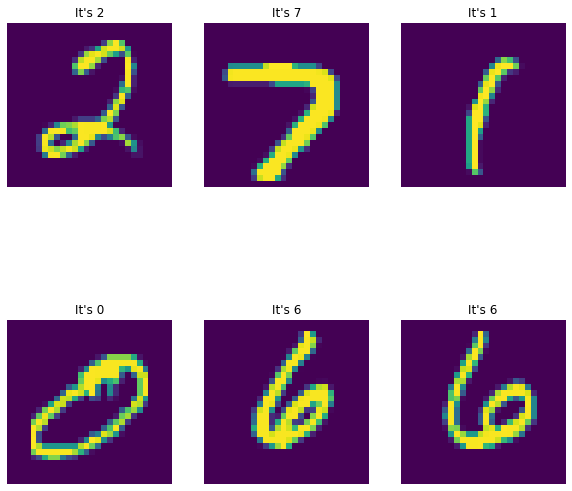

In [ ]:
fig, ax = plt.subplots(2, 3, figsize=(10, 10))
for image, number in train_loader:
    for i in range(2):
        for j in range(3):
            ax[i, j].imshow(image[i * 3 + j].reshape(28, 28))
            ax[i, j].set_title(f'It\'s {number[i * 3 + j]}')
            ax[i, j].axis('off')
    break
fig.show()

## Подготовка нейросети

Опишите класс нейросети `ConvNet`: в его конструкторе инициализируйте слои нейросети. В функции `forward` на вход подается батч из картинок, а на выход &mdash; результат классификатора (пройденные через слои картинки).

**Вам могут понадобиться:**

1. Классы из модуля [`torch.nn`](https://pytorch.org/docs/stable/nn.html) для обучения:
    1. `nn.Conv2d` &mdash; двумерная свёртка
    3. `nn.Linear` &mdash; обычный линейный слой 
2. Класс из модуля `torch.nn` для отбора значений и борьбы с переобучением:
    1. `nn.MaxPool2d` &mdash; двумерный MaxPool
    2. `nn.Dropout` &mdash; случайное отключение нейронов
3. Классы из модуля `torch.nn` для функций нелинейности:
    1. `nn.ReLU` &mdash; ReLU
    2. `nn.Softmax` &mdash; Softmax
4. И, наконец, класс из `torch.nn` для связи остальных компонентов:
    1. `nn.Sequential`


In [ ]:
class ConvNet(nn.Module):
    def __init__(self, out_features=10):
        super().__init__()
        self.blocks = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding='same'),
            nn.ReLU(),
            nn.Conv2d(16, 16, 3, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(16, 32, 3, padding='same'),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Flatten(),
            nn.Linear(1568, out_features),
            nn.LogSoftmax(1)
        )
    
    def forward(self, x):
        return self.blocks(x)

Посмотрим, доступна ли видеокарта для вычислений. Если этот ноутбук открыт в Google Colab, убедитесь, что он запущен в среде с GPU (Меню -> Runtime -> Change runtime type -> Hardware accelerator: GPU). 

In [ ]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
if str(device) == 'cuda:0':
    is_gpu_available = 'доступна, вычисления будут на GPU'
else:
    is_gpu_available = 'недоступна, вычисления будут на CPU'
print(f'Статус доступности видеокарты: {is_gpu_available}')

Статус доступности видеокарты: доступна, вычисления будут на GPU


Инициализируйте модель, а также задайте [оптимизатор](https://pytorch.org/docs/stable/optim.html) градиентного спуска (например, Adam или SGD), [функционал ошибки](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html?highlight=crossentropyloss) и количетсво эпох обучения:

In [ ]:
model = ConvNet()
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
criterion = nn.NLLLoss()
n_epochs = 10

Перенесём модель на видеокарту, чтобы в разы ускорить вычисления.

In [ ]:
model.to(device)

ConvNet(
  (blocks): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (6): ReLU()
    (7): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Flatten(start_dim=1, end_dim=-1)
    (11): Linear(in_features=1568, out_features=10, bias=True)
    (12): LogSoftmax(dim=1)
  )
)

## Обучение и тестирование

В качестве метрики будем использовать точность предсказаний, её подсчитать можно при помощи `accuracy_score`:

In [ ]:
from sklearn.metrics import accuracy_score

Вспомогательная функция, которая принимает список точностей на обучающей и на тестировочной выборке после каждой эпохи и строит график:

In [ ]:
def plot_loss_accuracy(train_losses, train_accs, test_accs):
    clear_output(True)
    fig, ax = plt.subplots(1, 2, figsize=(26,10))
    ax[0].set_title('Train Loss')
    ax[0].plot(train_losses)
    ax[1].set_title('Accuracy')
    ax[1].plot(train_accs, label='Train')
    ax[1].plot(test_accs, label='Test')
    ax[1].legend()
    plt.grid()
    plt.show()

Напишите функции обучения одной эпохи, подсчёт предсказания и полного обучения нейросети.


*Процесс обучения одной эпохи:*
1. Обнуление градиента оптимизатора
2. Вычисление предсказаний
3. Подсчет ошибки
4. Вычисление антиградиента функционала ошибки
5. Спуск оптимизатора по антиградиенту

*Не забывайте до работы с моделью переводить все тензоры на GPU, а перед подсчётом точности отсоединять нужные тензоры и переводить их на CPU при помощи `.detach().cpu()`*

In [ ]:
def train_epoch(model, train_loader, criterion, optimizer, device='cpu'):
    model.train()
    train_losses = []
    train_accuracy = []

    for batch_X, batch_Y in tqdm(train_loader):
        batch_X = batch_X.to(device)
        batch_Y = batch_Y.to(device)

        optimizer.zero_grad()
        probs = model(batch_X)
        classes = torch.argmax(probs, dim=-1)
        loss = criterion(probs, batch_Y)
        loss.backward()

        train_losses.append(loss.item())
        train_accuracy.append((classes == batch_Y).float().mean().item())
        optimizer.step()
    
    return np.mean(train_losses), np.mean(train_accuracy)


def predict(model, test_loader, criterion, device='cpu'):
    model.eval()
    test_accuracy = []
    with torch.no_grad():
        for batch_X, batch_Y in tqdm(test_loader):
            batch_X = batch_X.to(device)
            batch_Y = batch_Y.to(device)

            probs = model(batch_X)
            classes = torch.argmax(probs, dim=-1)
            test_accuracy.append((classes == batch_Y).float().mean().item())
    return np.mean(test_accuracy)


def train(model, train_loader, test_loader, criterion, optimizer, n_epochs, device='cpu'):
    train_losses = []
    train_accs = []
    test_accs = []

    for epoch in range(n_epochs):
        loss, accs = train_epoch(model, train_loader, criterion, optimizer, device)
        train_losses.append(loss)
        train_accs.append(accs)
        test_accs.append(predict(model, test_loader, criterion, device))
        plot_loss_accuracy(train_losses, train_accs, test_accs)


Запустите обучение нейросети:

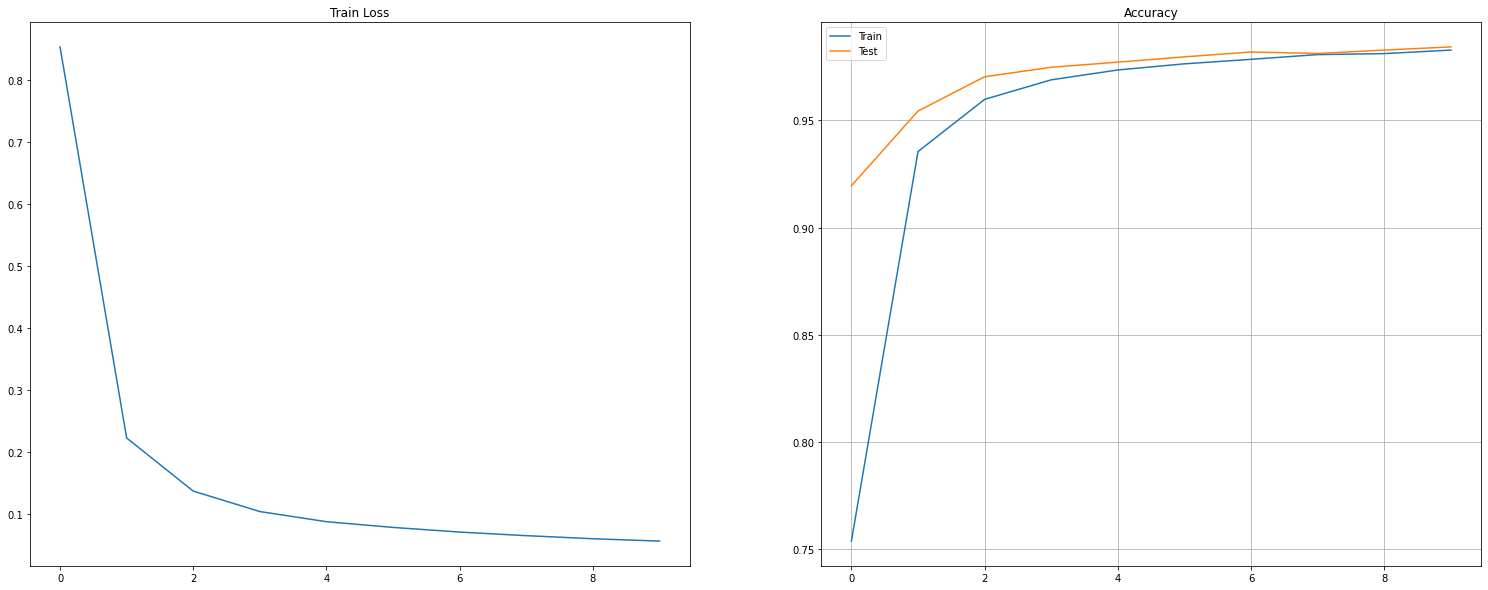

In [ ]:
train(model, train_loader, test_loader, criterion, optimizer, n_epochs, device)

## Перенос обучения

Одним из мощных инструментов в глубинном обучении является перенос обучения (Transer Learning).
Суть приёма заключается в том, что для решения задачи мы не собираем новую модель и обучаем её с нуля, а используем другую предобученную другую, и дообучаем её под поставленную задачу.

В данной задаче будем использовать модель ResNet-50: большую нейросеть, которая была сконструирована для соревнования [ImageNet](https://ru.wikipedia.org/wiki/ImageNet). Она классифицирует цветные изображения, каждое изоражение принадлежит одному из 1000 классов. Текущая задача другая: изображения чёрно-белые, и классов 10, а не 1000, поэтому изменим структуру ResNet. 

In [ ]:
def sample_and_rotate(x):
    angles = [0, 90, 180, 270]
    label = np.random.choice(np.arange(len(angles)))
    
    rotated = transforms.functional.rotate(x, angles[label])
    return rotated, label

In [ ]:
tt = transforms.ToTensor()
nm = transforms.Normalize((0.5,), (0.5,))
transform_first = lambda x: (nm(tt(x[0])), x[1])
sampled_rotation_transform = transforms.Lambda(
    lambda x: transform_first(sample_and_rotate(x)))

rotation_dataset = torchvision.datasets.MNIST('./files/', train=True, download=True, transform=sampled_rotation_transform)
rotation_loader = DataLoader(rotation_dataset, batch_size=batch_size, shuffle=True)

Label: 0


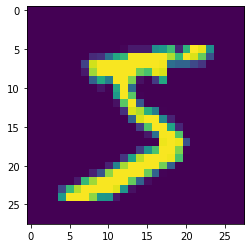

In [ ]:
sample_image, label = rotation_dataset[0][0]

plt.imshow(0.5 * (sample_image.permute(1, 2, 0).squeeze() + 1))
print("Label:", label)

In [ ]:
model = ConvNet(4).to(device)
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
criterion = nn.NLLLoss()
n_epochs = 5

In [ ]:
def train_epoch_rotation(model, train_loader, criterion, optimizer, device='cpu'):
    model.train()
    train_losses = []
    train_accuracy = []

    for (batch_X, batch_Y), _ in tqdm(train_loader):
        batch_X = batch_X.to(device)
        batch_Y = batch_Y.to(device)

        optimizer.zero_grad()
        probs = model(batch_X)
        classes = torch.argmax(probs, dim=-1)
        loss = criterion(probs, batch_Y)
        loss.backward()

        train_losses.append(loss.item())
        train_accuracy.append((classes == batch_Y).float().mean().item())
        optimizer.step()
    
    return np.mean(train_losses), np.mean(train_accuracy)


def train_rotation(model, train_loader, criterion, optimizer, n_epochs, device='cpu'):
    train_losses = []
    train_accs = []
    test_accs = []

    for epoch in range(n_epochs):
        loss, accs = train_epoch_rotation(model, train_loader, criterion, optimizer, device)
        train_losses.append(loss)
        train_accs.append(accs)
        plot_loss_accuracy(train_losses, train_accs, [])


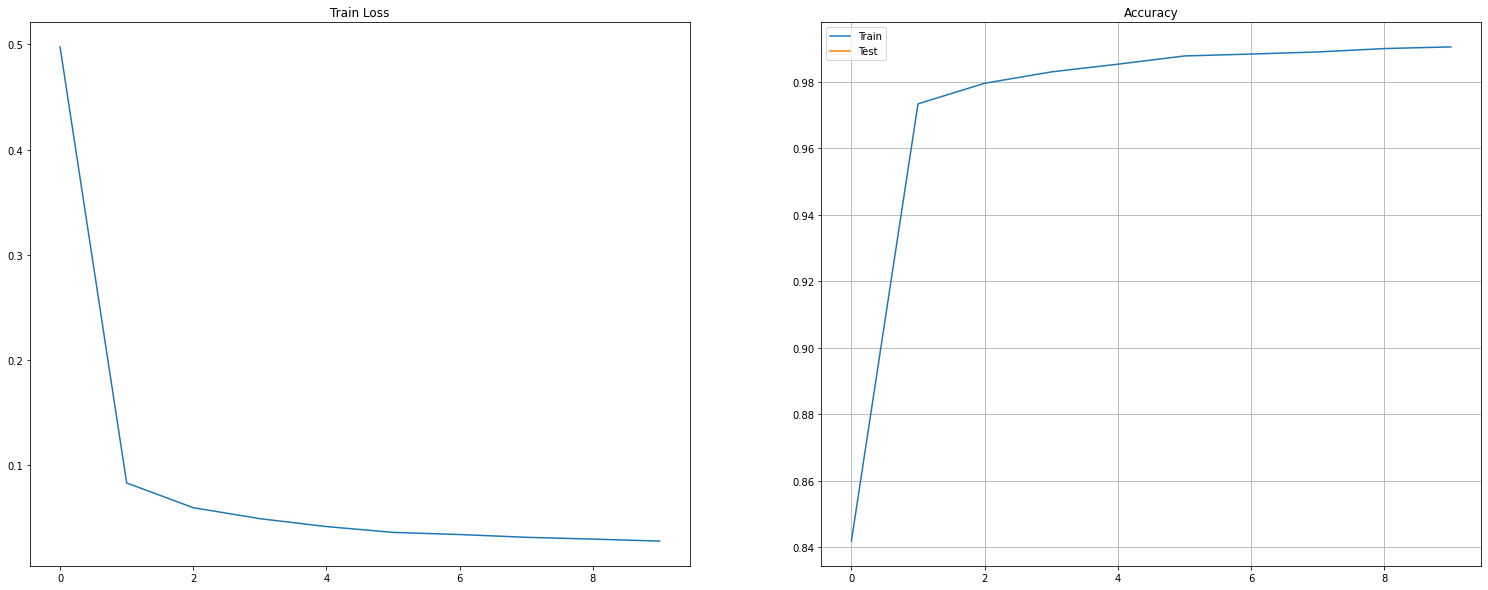

In [ ]:
train_rotation(model, rotation_loader, criterion, optimizer, n_epochs, device)

In [ ]:
model.blocks[-2] = nn.Linear(1568, 10)
optimizer = torch.optim.Adam(model.blocks[-2].parameters(), 1e-4)
criterion = nn.NLLLoss()
n_epochs = 10
model.to(device)

ConvNet(
  (blocks): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (6): ReLU()
    (7): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Flatten(start_dim=1, end_dim=-1)
    (11): Linear(in_features=1568, out_features=10, bias=True)
    (12): LogSoftmax(dim=1)
  )
)

In [ ]:
from copy import deepcopy
tmp = deepcopy(model)

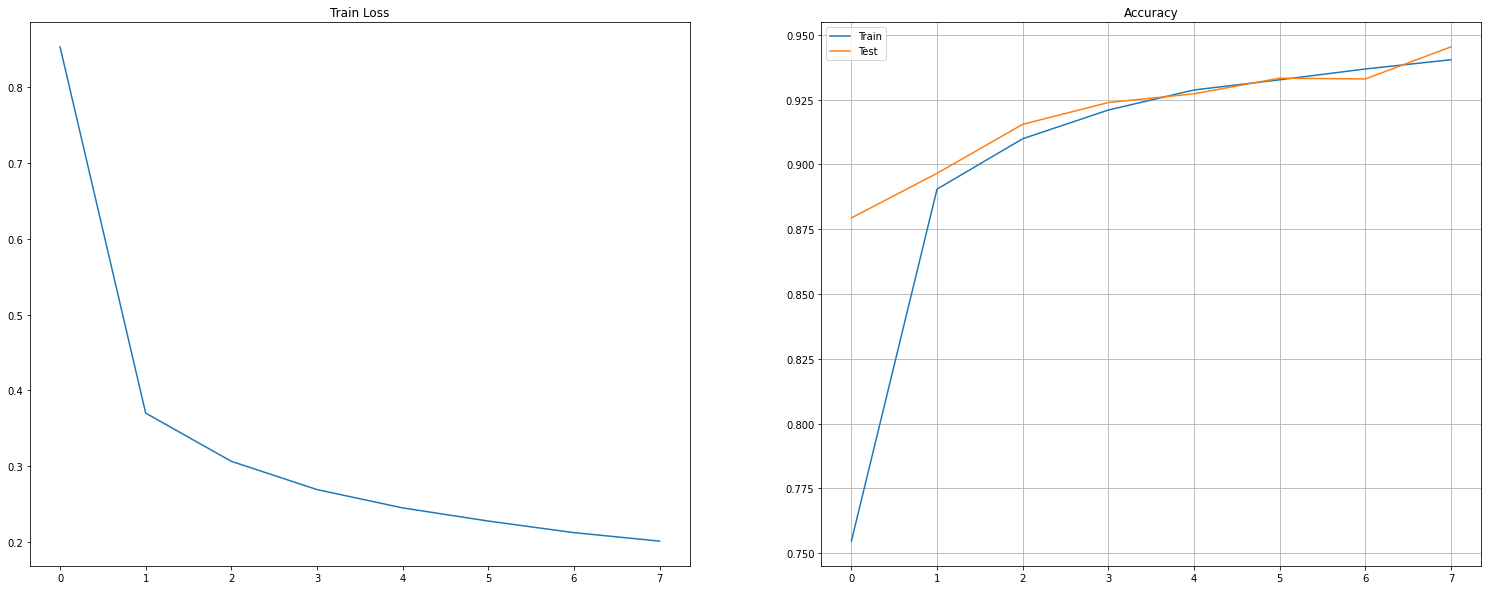

In [ ]:
train(model, train_loader, test_loader, criterion, optimizer, n_epochs, device)

In [ ]:
model = deepcopy(tmp)
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
criterion = nn.NLLLoss()
n_epochs = 10
model.to(device)

ConvNet(
  (blocks): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (6): ReLU()
    (7): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Flatten(start_dim=1, end_dim=-1)
    (11): Linear(in_features=1568, out_features=10, bias=True)
    (12): LogSoftmax(dim=1)
  )
)

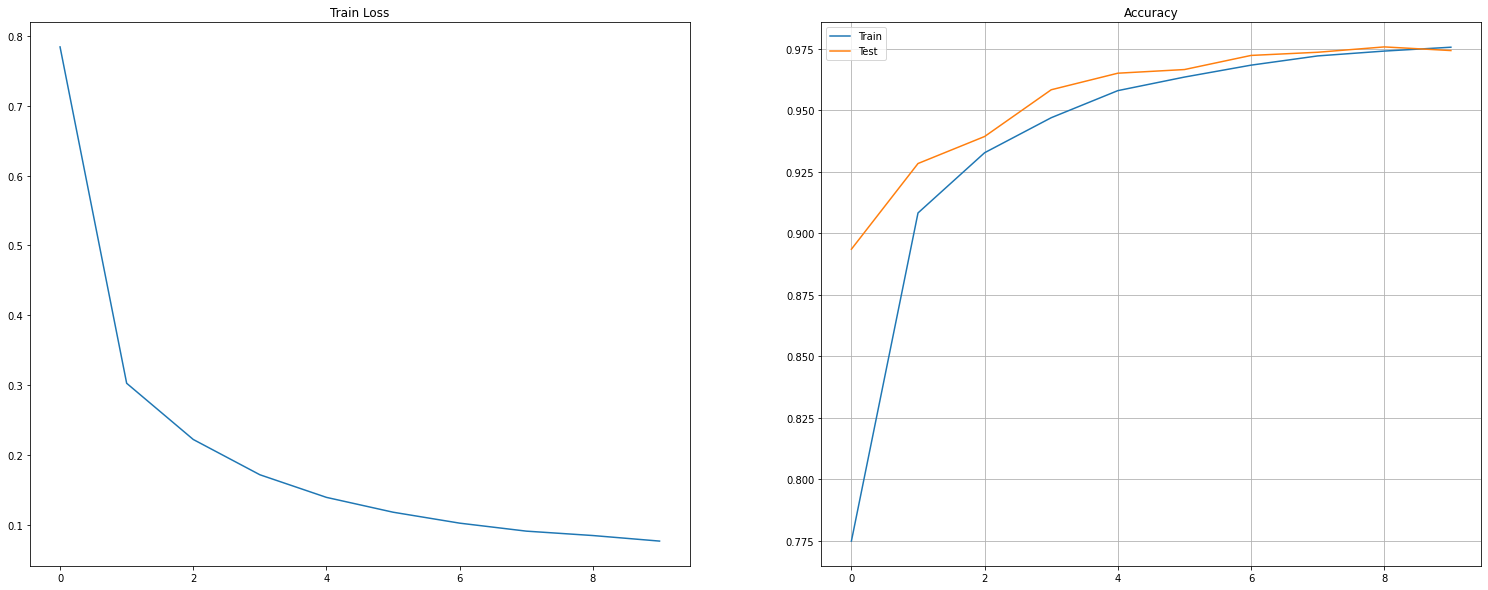

In [ ]:
train(model, train_loader, test_loader, criterion, optimizer, n_epochs, device)